## Import Package

In [94]:
import pandas as pd
from pmdarima.arima import ndiffs
from matplotlib import pyplot as plt 
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.stattools import adfuller  # Correct import
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

## Data Process

In [95]:
Copper_price = pd.read_csv('Data/Copper-price.csv')
Copper_price.rename(columns={'Close/Last':"Close"}, inplace=True)
#Copper_price.drop(columns=['Volume', 'Open', 'High', 'Low'], inplace=True)
Copper_price.head()

,Date,Close,Volume,Open,High,Low
0,08/13/2024,4.0855,20096,4.1005,4.109,4.0455
1,08/12/2024,4.0685,48834,3.9830,4.093,3.9710
2,08/09/2024,3.9930,48657,3.9835,4.049,3.9740
3,08/08/2024,3.9590,61544,3.9315,3.984,3.9235
4,08/07/2024,3.9520,62696,4.0080,4.016,3.9210


### Set time to index

In [96]:
Copper_price["Date"] = pd.to_datetime(Copper_price["Date"])
data = Copper_price.set_index("Date")
data.head()

,Close,Volume,Open,High,Low
Date,,,,,
2024-08-13,4.0855,20096,4.1005,4.109,4.0455
2024-08-12,4.0685,48834,3.9830,4.093,3.9710
2024-08-09,3.9930,48657,3.9835,4.049,3.9740
2024-08-08,3.9590,61544,3.9315,3.984,3.9235
2024-08-07,3.9520,62696,4.0080,4.016,3.9210


<Axes: xlabel='Date'>

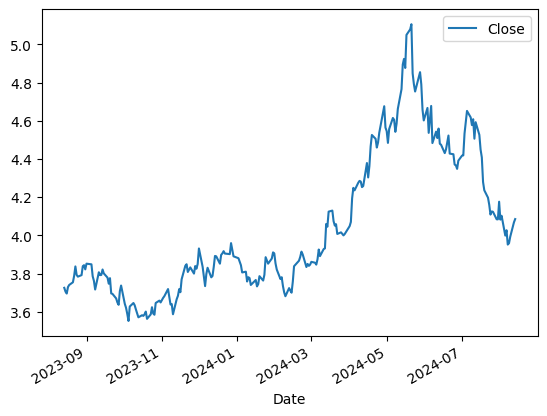

In [97]:
data[['Close']].plot()

### Test stationarity

In [98]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")

adf_test(data['Close'])

Results of Dickey-Fuller Test
Test Statistic                  -1.027806
p-value                          0.742988
#Lags Used                       0.000000
Number of Observations Used    251.000000
Criterical Value (1%)           -3.456674
Criterical Value (5%)           -2.873125
Criterical Value (10%)          -2.572944
dtype: float64
The data is non-stationary, so do differencing!


### differencing|

In [103]:
result = adfuller(data['Close'])
print('Dickey-Fuller Test Results (Original Data):')
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

# Perform first differencing
data_diff = data['Close'].diff(5).dropna()

Dickey-Fuller Test Results (Original Data):
Test Statistic: -1.0278061167706085
p-value: 0.7429880628789449
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}


In [104]:
adf_test(data_diff)

Results of Dickey-Fuller Test
Test Statistic                  -3.446820
p-value                          0.009463
#Lags Used                      10.000000
Number of Observations Used    236.000000
Criterical Value (1%)           -3.458366
Criterical Value (5%)           -2.873866
Criterical Value (10%)          -2.573339
dtype: float64
The data is stationary. (Criterical Value 5%)


## ARIMA Model

### Grid Search to find best parameter

In [105]:

def find_best_arima(data, p_values, d_values, q_values):
    best_aic = np.inf
    best_order = None
    best_model = None

    # Iterate over all possible combinations of p, d, q
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            # Fit the ARIMA model
            model = ARIMA(data, order=(p, d, q))
            model_fit = model.fit()
            
            # Check if the current model has the lowest AIC
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
                best_model = model_fit
        
        except Exception as e:
            continue

    return best_order, best_aic, best_model

# Define the range of p, d, q values
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

# Call the function to find the best ARIMA model
best_order, best_aic, best_model = find_best_arima(data_diff, p_values, d_values, q_values)

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

Best ARIMA order: (0, 0, 4) with AIC: -717.8098040629311


In [113]:
price_for[0]

0.0

In [114]:
data['Close'][0]

4.0855

In [121]:
diff_forecast = diff_forecast.reindex()

In [124]:
list(diff_forecast)[0]

-0.012686948247657167

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  247
Model:                 ARIMA(0, 0, 4)   Log Likelihood                 364.905
Date:                Wed, 14 Aug 2024   AIC                           -717.810
Time:                        15:09:07   BIC                           -696.753
Sample:                             0   HQIC                          -709.332
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0075      0.018     -0.425      0.671      -0.042       0.027
ma.L1          1.0182      0.261      3.906      0.000       0.507       1.529
ma.L2          1.0507      0.171      6.162      0.0

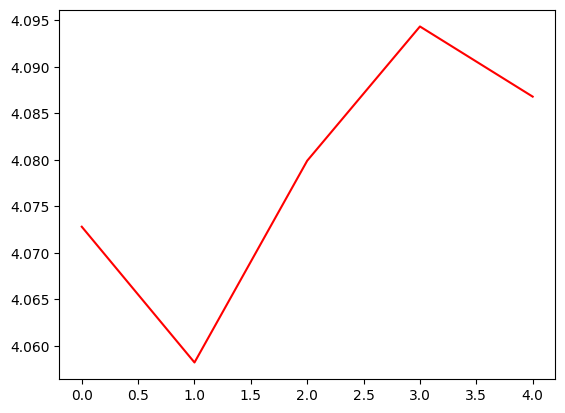

In [128]:
model = ARIMA(data_diff, order=best_order)
model_fit = model.fit()

# 模型摘要
print(model_fit.summary())

# 预测未来30天
diff_forecast = list(model_fit.forecast(steps=5))
print(diff_forecast)


price_for = np.zeros(len(diff_forecast))
price_for[0] = data['Close'][0] + diff_forecast[0]

for i in range(1, len(diff_forecast)):
    price_for[i] = price_for[i-1] + diff_forecast[i]

# 输出转换后的价格预测
print(price_for)

plt.plot(price_for, label='Forecast', color='red')
plt.show()